In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


In [20]:
# ===================== 1. Define Scope =====================
# Objective: Predict company valuation based on financial and categorical features

In [23]:
# ===================== 2 & 3. Data Collection & Cleaning =====================
file_path = '/content/unicorns till sep 2022.csv'

try:
    data = pd.read_csv(file_path)
    print("Data successfully loaded!")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
    data = None

if data is not None:
    # Rename columns for easier access
    data.columns = ['Company', 'Valuation_B', 'Date_Joined', 'Country', 'City', 'Industry', 'Investors']

    # Drop rows with missing critical values
    data.dropna(subset=['Valuation_B', 'Country', 'Industry', 'Date_Joined'], inplace=True)

    # Clean target variable 'Valuation_B'
    data['Valuation_B'] = data['Valuation_B'].astype(str)\
        .str.replace('$', '', regex=False)\
        .str.replace('B', '', regex=False)\
        .str.strip()
    data['Valuation_B'] = pd.to_numeric(data['Valuation_B'], errors='coerce')
    data.dropna(subset=['Valuation_B'], inplace=True)
    print(f"Data after cleaning: {data.shape[0]} rows.")

Data successfully loaded!
Data after cleaning: 1186 rows.



--- EDA ---

Valuation ($B) Descriptive Stats:
 count    1186.000000
mean        3.251282
std         7.641574
min         1.000000
25%         1.100000
50%         1.600000
75%         3.000000
max       140.000000
Name: Valuation_B, dtype: float64


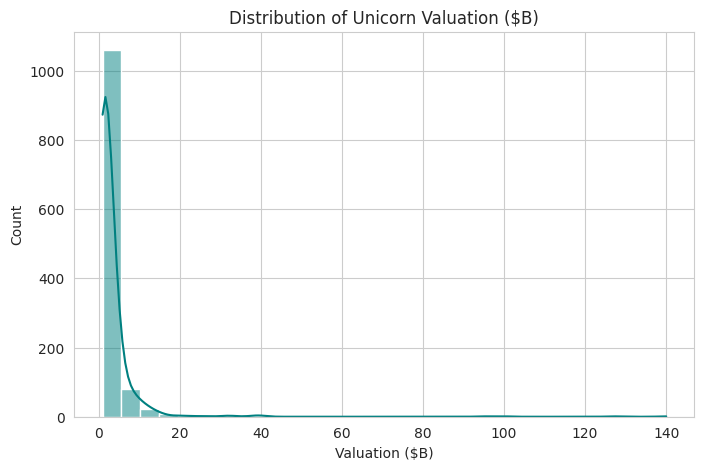

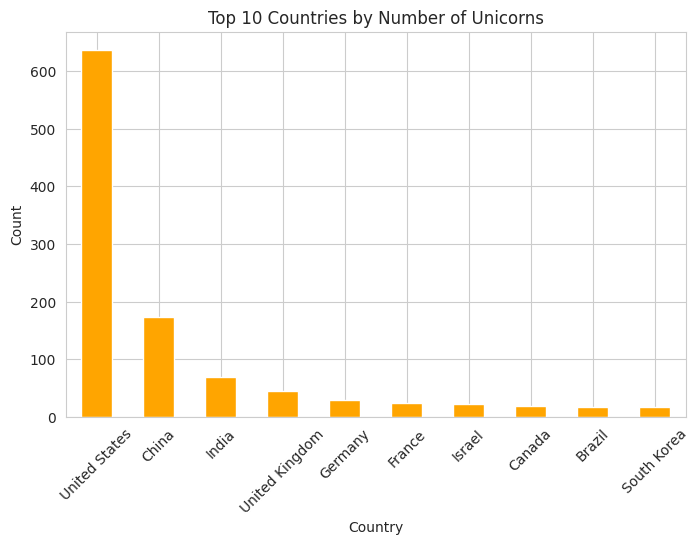

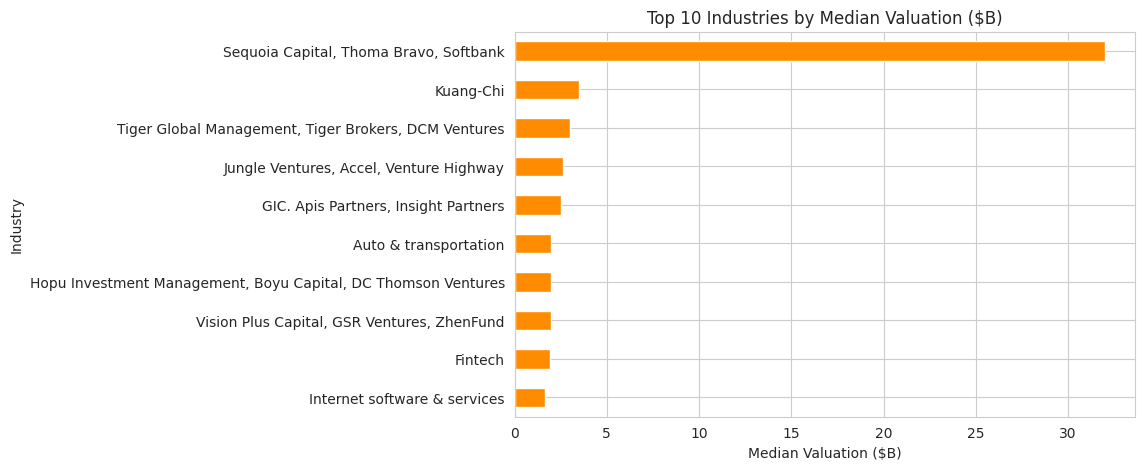

In [25]:
# ===================== 4. Exploratory Data Analysis (EDA) =====================
print("\n--- EDA ---")
print("\nValuation ($B) Descriptive Stats:\n", data['Valuation_B'].describe())

# Distribution of Valuation
plt.figure(figsize=(8,5))
sns.histplot(data['Valuation_B'], bins=30, kde=True, color='teal')
plt.title('Distribution of Unicorn Valuation ($B)')
plt.xlabel('Valuation ($B)')
plt.show()

# Top 10 countries by number of unicorns
plt.figure(figsize=(8,5))
data['Country'].value_counts().nlargest(10).plot(kind='bar', color='orange')
plt.title('Top 10 Countries by Number of Unicorns')
plt.ylabel('Count')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()

# Top 10 industries by median valuation
industry_median_val = data.groupby('Industry')['Valuation_B'].median().sort_values(ascending=False).nlargest(10)
plt.figure(figsize=(8,5))
industry_median_val.plot(kind='barh', color='darkorange')
plt.title('Top 10 Industries by Median Valuation ($B)')
plt.xlabel('Median Valuation ($B)')
plt.ylabel('Industry')
plt.gca().invert_yaxis()
plt.show()

In [28]:
# ===================== 5. Feature Engineering =====================
data['Year_Joined'] = pd.to_datetime(data['Date_Joined'], errors='coerce').dt.year
data.dropna(subset=['Year_Joined'], inplace=True)
data['Year_Joined'] = data['Year_Joined'].astype(int)

# Features and Target
X = data.drop(['Company', 'Valuation_B', 'Date_Joined', 'City', 'Investors'], axis=1)
y = data['Valuation_B']

# Group low-frequency categories
def group_low_frequency(df, column, threshold=10):
    counts = df[column].value_counts()
    rare = counts[counts < threshold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare else x)
    return df

X = group_low_frequency(X, 'Country', threshold=10)
X = group_low_frequency(X, 'Industry', threshold=15)
print("Features after grouping rare categories:\n", X.head())

# Identify numerical and categorical features
numerical_features = ['Year_Joined']
categorical_features = ['Country', 'Industry']

Features after grouping rare categories:
          Country                         Industry  Year_Joined
0          China          Artificial intelligence         2017
1  United States                            Other         2012
2          China  E-commerce & direct-to-consumer         2018
3  United States                          Fintech         2014
4          Other     Internet software & services         2018


In [30]:
# ===================== 6. Model Selection and Training =====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

model_pipeline.fit(X_train, y_train)
print("Random Forest Regressor trained successfully.")

Random Forest Regressor trained successfully.



Model Evaluation:
MAE: $1.95 B
R2 Score: -0.8068


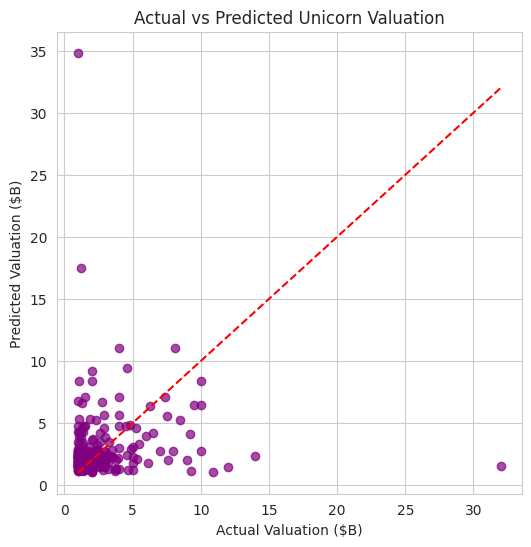

In [32]:
# ===================== 7. Model Evaluation =====================
y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nModel Evaluation:\nMAE: ${mae:.2f} B\nR2 Score: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Valuation ($B)')
plt.ylabel('Predicted Valuation ($B)')
plt.title('Actual vs Predicted Unicorn Valuation')
plt.show()

In [34]:
# ===================== 8. Model Tuning and Optimization =====================
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=0)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_mae = -grid_search.best_score_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV MAE: ${best_mae:.2f} B")


Best Parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 100}
Best CV MAE: $2.81 B


In [36]:
# ===================== 9. Deployment (Prediction Function) =====================
def predict_valuation(country, industry, year, model=best_model):
    new_data = pd.DataFrame({
        'Country': [country],
        'Industry': [industry],
        'Year_Joined': [year]
    })
    pred = model.predict(new_data)[0]
    return f"Predicted Unicorn Valuation: ${pred:.2f} B"

# Example Prediction
example_prediction = predict_valuation(country='India', industry='Fintech', year=2022)
print("\nExample Prediction:", example_prediction)


Example Prediction: Predicted Unicorn Valuation: $1.63 B
